In [1]:
from sympy import *
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
t = symbols('t')
#states
x = Function('x')(t)
y = Function('y')(t)
z = Function('z')(t)
th0 = Function('θ_0')(t)
th1 = Function('θ_1')(t)
th2 = Function('θ_2')(t)
all_states = [x,y,z,th0,th1,th2]

#parameters
R1, R2, R3, R4 = symbols('R_1 R_2 R_3 R_4')
m, g = symbols('m g')

#Visuals
#use clean() to render d/dt as dots and remove the (t) in functions

dots = {}
no_t = {}
for state in all_states:
    d_disp = Function('\dot{' + state.name + '}')(t)
    dd_disp = Function('\ddot{' + state.name + '}')(t)
    dots[state.diff(t)] = d_disp
    dots[d_disp.diff(t)] = dd_disp
    no_t[state] = symbols(state.name)
    no_t[d_disp] = symbols('\dot{' + state.name + '}')
    no_t[dd_disp] = symbols('\ddot{' + state.name + '}')
clean = lambda expr : expr.subs(dots).subs(dots).subs(no_t)
half = Rational(1,2)    #keep as fraction rather than floating point

clean(th0.diff(t))

\dot{θ_0}

In [3]:
'''Kinematics'''
from util.util import format_transform, rot_xyz_sympy
from numpy import array

#translate then rotate
p = array([0, 0, 0])
R = rot_xyz_sympy('z', th0)
H_yaw = format_transform(R,p) #frame at origin that rotates with base

p = array([0, R1, 0])
R = rot_xyz_sympy('x', th1)
H_roll_rel = format_transform(R,p)
H_roll = H_yaw @ H_roll_rel # frame at joint θ1 that rotates with θ1

p = array([0, 0, R2])
R = rot_xyz_sympy('y', th2)
H_pitch_rel = format_transform(R,p)
H_pitch = H_roll @ H_pitch_rel # frame at joint θ2 that rotates with θ2

p = array([0, R3, 0])
R = eye(3)
H_elbow_rel = format_transform(R,p)
H_elbow = H_pitch @ H_elbow_rel # frame at elbow between joint θ2 and end eff

p = array([0, 0, -R4])
R = eye(3)
H_eff_rel = format_transform(R,p)
H_eff = H_elbow @ H_eff_rel # frame at end eff


H_yaw = Matrix(H_yaw)
H_roll = Matrix(H_roll)
H_pitch = Matrix(H_pitch)
H_elbow = Matrix(H_elbow)
H_eff = Matrix(H_eff)

clean(H_eff)

Matrix([
[-sin(θ_0)*sin(θ_1)*sin(θ_2) + cos(θ_0)*cos(θ_2), -sin(θ_0)*cos(θ_1), sin(θ_0)*sin(θ_1)*cos(θ_2) + sin(θ_2)*cos(θ_0), -R_1*sin(θ_0) + R_2*sin(θ_0)*sin(θ_1) - R_3*sin(θ_0)*cos(θ_1) - R_4*(sin(θ_0)*sin(θ_1)*cos(θ_2) + sin(θ_2)*cos(θ_0))],
[ sin(θ_0)*cos(θ_2) + sin(θ_1)*sin(θ_2)*cos(θ_0),  cos(θ_0)*cos(θ_1), sin(θ_0)*sin(θ_2) - sin(θ_1)*cos(θ_0)*cos(θ_2),  R_1*cos(θ_0) - R_2*sin(θ_1)*cos(θ_0) + R_3*cos(θ_0)*cos(θ_1) - R_4*(sin(θ_0)*sin(θ_2) - sin(θ_1)*cos(θ_0)*cos(θ_2))],
[                             -sin(θ_2)*cos(θ_1),           sin(θ_1),                              cos(θ_1)*cos(θ_2),                                                                  R_2*cos(θ_1) + R_3*sin(θ_1) - R_4*cos(θ_1)*cos(θ_2)],
[                                              0,                  0,                                              0,                                                                                                                    1]])

0

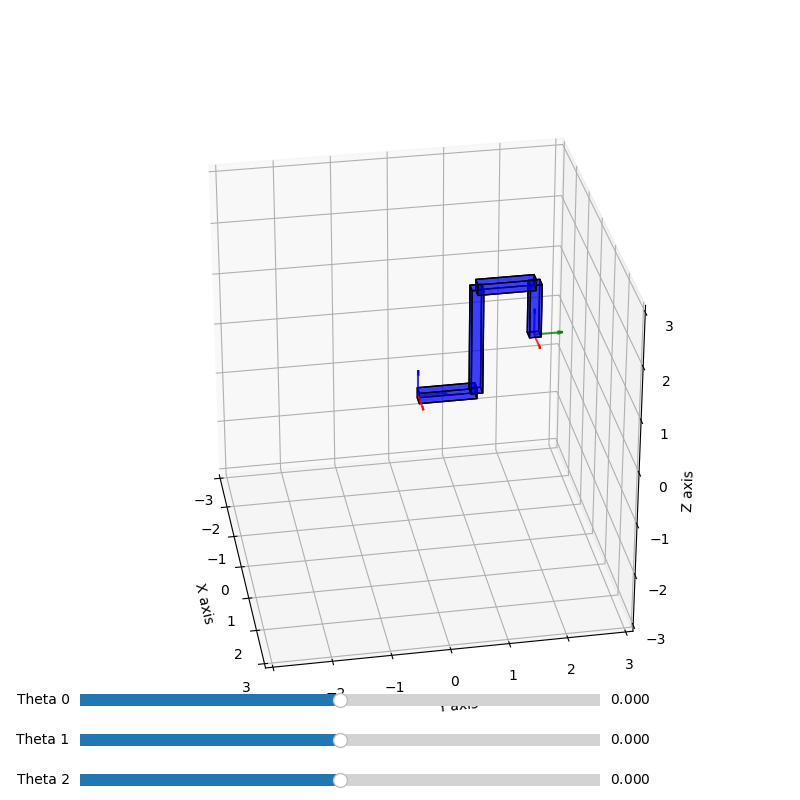

In [4]:
''' Visualization '''
from util.plotcube import *
from util.util import extract_R_p_from_transformation
from matplotlib.widgets import Slider
%matplotlib widget

Rs = {
    R1: 1,
    R2: 2, 
    R3: 1,
    R4: 1 
}

fig, ax = init_3d_plot(cube_lim=3)

axcolor = 'lightgoldenrodyellow'
ax_theta0 = plt.axes([0.1, 0.11, 0.65, 0.03], facecolor=axcolor)
ax_theta1 = plt.axes([0.1, 0.06, 0.65, 0.03], facecolor=axcolor)
ax_theta2 = plt.axes([0.1, 0.01, 0.65, 0.03], facecolor=axcolor)
s_theta0 = Slider(ax_theta0, 'Theta 0', -np.pi, np.pi, valinit=0)
s_theta1 = Slider(ax_theta1, 'Theta 1', -np.pi, np.pi, valinit=0)
s_theta2 = Slider(ax_theta2, 'Theta 2', -np.pi, np.pi, valinit=0)

def update(val=None):
    ax.cla()  # Clear the current axes
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])

    ax.view_init(elev=30, azim=-10)  # Set the default view from the y-axis

    thetas = {
        th0: s_theta0.val,
        th1: s_theta1.val,
        th2: s_theta2.val,
    }
    plot_frame(ax, R=eye(3), p=(0,0,0), lengths=0.5)

    R, p = extract_R_p_from_transformation(H_yaw.subs(Rs).subs(thetas))
    plot_link(ax, R, p, size=(0.1, Rs[R1], 0.1), long_ax='y')

    R, p = extract_R_p_from_transformation(H_roll.subs(Rs).subs(thetas))
    plot_link(ax, R, p, size=(0.1, 0.1, Rs[R2]), long_ax='z')

    R, p = extract_R_p_from_transformation(H_pitch.subs(Rs).subs(thetas))
    plot_link(ax, R, p, size=(0.1, Rs[R3], 0.1), long_ax='y')

    R, p = extract_R_p_from_transformation(H_elbow.subs(Rs).subs(thetas))
    plot_link(ax, R, p, size=(0.1, 0.1, -Rs[R4]), long_ax='z')

    R, p = extract_R_p_from_transformation(H_eff.subs(Rs).subs(thetas))
    plot_frame(ax, R, p, lengths=0.5)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.draw()
update()
s_theta0.on_changed(update)
s_theta1.on_changed(update)
s_theta2.on_changed(update)

In [5]:
x = H_eff[0,3]
y = H_eff[1,3]
z = H_eff[2,3]

KE = half*m*(x.diff(t)**2 + y.diff(t)**2 + z.diff(t)**2)
PE = m*g*z
L = KE - PE

display(clean(KE), clean(PE), clean(L))

m*((-R_2*\dot{θ_1}*sin(θ_1) + R_3*\dot{θ_1}*cos(θ_1) + R_4*\dot{θ_1}*sin(θ_1)*cos(θ_2) + R_4*\dot{θ_2}*sin(θ_2)*cos(θ_1))**2 + (-R_1*\dot{θ_0}*sin(θ_0) + R_2*\dot{θ_0}*sin(θ_0)*sin(θ_1) - R_2*\dot{θ_1}*cos(θ_0)*cos(θ_1) - R_3*\dot{θ_0}*sin(θ_0)*cos(θ_1) - R_3*\dot{θ_1}*sin(θ_1)*cos(θ_0) - R_4*(\dot{θ_0}*sin(θ_0)*sin(θ_1)*cos(θ_2) + \dot{θ_0}*sin(θ_2)*cos(θ_0) - \dot{θ_1}*cos(θ_0)*cos(θ_1)*cos(θ_2) + \dot{θ_2}*sin(θ_0)*cos(θ_2) + \dot{θ_2}*sin(θ_1)*sin(θ_2)*cos(θ_0)))**2 + (-R_1*\dot{θ_0}*cos(θ_0) + R_2*\dot{θ_0}*sin(θ_1)*cos(θ_0) + R_2*\dot{θ_1}*sin(θ_0)*cos(θ_1) - R_3*\dot{θ_0}*cos(θ_0)*cos(θ_1) + R_3*\dot{θ_1}*sin(θ_0)*sin(θ_1) - R_4*(-\dot{θ_0}*sin(θ_0)*sin(θ_2) + \dot{θ_0}*sin(θ_1)*cos(θ_0)*cos(θ_2) + \dot{θ_1}*sin(θ_0)*cos(θ_1)*cos(θ_2) - \dot{θ_2}*sin(θ_0)*sin(θ_1)*sin(θ_2) + \dot{θ_2}*cos(θ_0)*cos(θ_2)))**2)/2

g*m*(R_2*cos(θ_1) + R_3*sin(θ_1) - R_4*cos(θ_1)*cos(θ_2))

-g*m*(R_2*cos(θ_1) + R_3*sin(θ_1) - R_4*cos(θ_1)*cos(θ_2)) + m*((-R_2*\dot{θ_1}*sin(θ_1) + R_3*\dot{θ_1}*cos(θ_1) + R_4*\dot{θ_1}*sin(θ_1)*cos(θ_2) + R_4*\dot{θ_2}*sin(θ_2)*cos(θ_1))**2 + (-R_1*\dot{θ_0}*sin(θ_0) + R_2*\dot{θ_0}*sin(θ_0)*sin(θ_1) - R_2*\dot{θ_1}*cos(θ_0)*cos(θ_1) - R_3*\dot{θ_0}*sin(θ_0)*cos(θ_1) - R_3*\dot{θ_1}*sin(θ_1)*cos(θ_0) - R_4*(\dot{θ_0}*sin(θ_0)*sin(θ_1)*cos(θ_2) + \dot{θ_0}*sin(θ_2)*cos(θ_0) - \dot{θ_1}*cos(θ_0)*cos(θ_1)*cos(θ_2) + \dot{θ_2}*sin(θ_0)*cos(θ_2) + \dot{θ_2}*sin(θ_1)*sin(θ_2)*cos(θ_0)))**2 + (-R_1*\dot{θ_0}*cos(θ_0) + R_2*\dot{θ_0}*sin(θ_1)*cos(θ_0) + R_2*\dot{θ_1}*sin(θ_0)*cos(θ_1) - R_3*\dot{θ_0}*cos(θ_0)*cos(θ_1) + R_3*\dot{θ_1}*sin(θ_0)*sin(θ_1) - R_4*(-\dot{θ_0}*sin(θ_0)*sin(θ_2) + \dot{θ_0}*sin(θ_1)*cos(θ_0)*cos(θ_2) + \dot{θ_1}*sin(θ_0)*cos(θ_1)*cos(θ_2) - \dot{θ_2}*sin(θ_0)*sin(θ_1)*sin(θ_2) + \dot{θ_2}*cos(θ_0)*cos(θ_2)))**2)/2

In [6]:
#Euler-Lagrange
F0, F1, F2 = symbols('F0 F1 F2')
Eq_th0 = Eq(diff(diff(L, diff(th0)), t) - diff(L, th0), F0)
Eq_th1 = Eq(diff(diff(L, diff(th1)), t) - diff(L, th1), F1)
Eq_th2 = Eq(diff(diff(L, diff(th2)), t) - diff(L, th2), F2)

display(clean(Eq_th0), clean(Eq_th1), clean(Eq_th2))

Eq(-m*((-R_1*\dot{θ_0}*sin(θ_0) + R_2*\dot{θ_0}*sin(θ_0)*sin(θ_1) - R_2*\dot{θ_1}*cos(θ_0)*cos(θ_1) - R_3*\dot{θ_0}*sin(θ_0)*cos(θ_1) - R_3*\dot{θ_1}*sin(θ_1)*cos(θ_0) - R_4*(\dot{θ_0}*sin(θ_0)*sin(θ_1)*cos(θ_2) + \dot{θ_0}*sin(θ_2)*cos(θ_0) - \dot{θ_1}*cos(θ_0)*cos(θ_1)*cos(θ_2) + \dot{θ_2}*sin(θ_0)*cos(θ_2) + \dot{θ_2}*sin(θ_1)*sin(θ_2)*cos(θ_0)))*(-2*R_1*\dot{θ_0}*cos(θ_0) + 2*R_2*\dot{θ_0}*sin(θ_1)*cos(θ_0) + 2*R_2*\dot{θ_1}*sin(θ_0)*cos(θ_1) - 2*R_3*\dot{θ_0}*cos(θ_0)*cos(θ_1) + 2*R_3*\dot{θ_1}*sin(θ_0)*sin(θ_1) - 2*R_4*(-\dot{θ_0}*sin(θ_0)*sin(θ_2) + \dot{θ_0}*sin(θ_1)*cos(θ_0)*cos(θ_2) + \dot{θ_1}*sin(θ_0)*cos(θ_1)*cos(θ_2) - \dot{θ_2}*sin(θ_0)*sin(θ_1)*sin(θ_2) + \dot{θ_2}*cos(θ_0)*cos(θ_2))) + (2*R_1*\dot{θ_0}*sin(θ_0) - 2*R_2*\dot{θ_0}*sin(θ_0)*sin(θ_1) + 2*R_2*\dot{θ_1}*cos(θ_0)*cos(θ_1) + 2*R_3*\dot{θ_0}*sin(θ_0)*cos(θ_1) + 2*R_3*\dot{θ_1}*sin(θ_1)*cos(θ_0) - 2*R_4*(-\dot{θ_0}*sin(θ_0)*sin(θ_1)*cos(θ_2) - \dot{θ_0}*sin(θ_2)*cos(θ_0) + \dot{θ_1}*cos(θ_0)*cos(θ_1)*cos(θ_2) - 

Eq(g*m*(-R_2*sin(θ_1) + R_3*cos(θ_1) + R_4*sin(θ_1)*cos(θ_2)) - m*((-R_2*\dot{θ_1}*sin(θ_1) + R_3*\dot{θ_1}*cos(θ_1) + R_4*\dot{θ_1}*sin(θ_1)*cos(θ_2) + R_4*\dot{θ_2}*sin(θ_2)*cos(θ_1))*(-2*R_2*\dot{θ_1}*cos(θ_1) - 2*R_3*\dot{θ_1}*sin(θ_1) + 2*R_4*\dot{θ_1}*cos(θ_1)*cos(θ_2) - 2*R_4*\dot{θ_2}*sin(θ_1)*sin(θ_2)) + (2*R_2*\dot{θ_0}*sin(θ_0)*cos(θ_1) + 2*R_2*\dot{θ_1}*sin(θ_1)*cos(θ_0) + 2*R_3*\dot{θ_0}*sin(θ_0)*sin(θ_1) - 2*R_3*\dot{θ_1}*cos(θ_0)*cos(θ_1) - 2*R_4*(\dot{θ_0}*sin(θ_0)*cos(θ_1)*cos(θ_2) + \dot{θ_1}*sin(θ_1)*cos(θ_0)*cos(θ_2) + \dot{θ_2}*sin(θ_2)*cos(θ_0)*cos(θ_1)))*(-R_1*\dot{θ_0}*sin(θ_0) + R_2*\dot{θ_0}*sin(θ_0)*sin(θ_1) - R_2*\dot{θ_1}*cos(θ_0)*cos(θ_1) - R_3*\dot{θ_0}*sin(θ_0)*cos(θ_1) - R_3*\dot{θ_1}*sin(θ_1)*cos(θ_0) - R_4*(\dot{θ_0}*sin(θ_0)*sin(θ_1)*cos(θ_2) + \dot{θ_0}*sin(θ_2)*cos(θ_0) - \dot{θ_1}*cos(θ_0)*cos(θ_1)*cos(θ_2) + \dot{θ_2}*sin(θ_0)*cos(θ_2) + \dot{θ_2}*sin(θ_1)*sin(θ_2)*cos(θ_0))) + (2*R_2*\dot{θ_0}*cos(θ_0)*cos(θ_1) - 2*R_2*\dot{θ_1}*sin(θ_0)*sin(θ_1

Eq(R_4*g*m*sin(θ_2)*cos(θ_1) - m*(-2*R_4*(-\dot{θ_0}*sin(θ_0)*cos(θ_2) - \dot{θ_0}*sin(θ_1)*sin(θ_2)*cos(θ_0) - \dot{θ_1}*sin(θ_0)*sin(θ_2)*cos(θ_1) - \dot{θ_2}*sin(θ_0)*sin(θ_1)*cos(θ_2) - \dot{θ_2}*sin(θ_2)*cos(θ_0))*(-R_1*\dot{θ_0}*cos(θ_0) + R_2*\dot{θ_0}*sin(θ_1)*cos(θ_0) + R_2*\dot{θ_1}*sin(θ_0)*cos(θ_1) - R_3*\dot{θ_0}*cos(θ_0)*cos(θ_1) + R_3*\dot{θ_1}*sin(θ_0)*sin(θ_1) - R_4*(-\dot{θ_0}*sin(θ_0)*sin(θ_2) + \dot{θ_0}*sin(θ_1)*cos(θ_0)*cos(θ_2) + \dot{θ_1}*sin(θ_0)*cos(θ_1)*cos(θ_2) - \dot{θ_2}*sin(θ_0)*sin(θ_1)*sin(θ_2) + \dot{θ_2}*cos(θ_0)*cos(θ_2))) - 2*R_4*(-\dot{θ_0}*sin(θ_0)*sin(θ_1)*sin(θ_2) + \dot{θ_0}*cos(θ_0)*cos(θ_2) + \dot{θ_1}*sin(θ_2)*cos(θ_0)*cos(θ_1) - \dot{θ_2}*sin(θ_0)*sin(θ_2) + \dot{θ_2}*sin(θ_1)*cos(θ_0)*cos(θ_2))*(-R_1*\dot{θ_0}*sin(θ_0) + R_2*\dot{θ_0}*sin(θ_0)*sin(θ_1) - R_2*\dot{θ_1}*cos(θ_0)*cos(θ_1) - R_3*\dot{θ_0}*sin(θ_0)*cos(θ_1) - R_3*\dot{θ_1}*sin(θ_1)*cos(θ_0) - R_4*(\dot{θ_0}*sin(θ_0)*sin(θ_1)*cos(θ_2) + \dot{θ_0}*sin(θ_2)*cos(θ_0) - \dot{θ_1}*co

In [7]:
clean(Eq_th0).has(symbols('\\ddot{θ_2}'))

True

In [63]:
simp_dict = {
    th0.name:0, # θ_0
    th1.name:0, # θ_1
    th2.name:0, # θ_1
    symbols('\\dot{θ_0}'): 0,
    symbols('\\dot{θ_1}'): 0,
    # symbols('\\dot{θ_2}'): 0,
    F0: 0,
    F1: 0,
    # R1: 0
    # th2:0,
}

Eq_th0_canceled = cancel(clean(Eq_th0).subs(simp_dict))
Eq_th1_canceled = cancel(clean(Eq_th1).subs(simp_dict))
Eq_th2_canceled = cancel(clean(Eq_th2).subs(simp_dict))

display(expand(trigsimp(Eq_th0_canceled)))
display(expand(trigsimp(Eq_th1_canceled)))
display(expand(trigsimp(Eq_th2_canceled)))


Eq(R_1**2*\ddot{θ_0}*m + 2*R_1*R_3*\ddot{θ_0}*m + R_1*R_4*\ddot{θ_2}*m + R_3**2*\ddot{θ_0}*m + R_3*R_4*\ddot{θ_2}*m, 0)

Eq(R_2**2*\ddot{θ_1}*m - 2*R_2*R_4*\ddot{θ_1}*m + R_3**2*\ddot{θ_1}*m + R_3*R_4*\dot{θ_2}**2*m + R_3*g*m + R_4**2*\ddot{θ_1}*m, 0)

Eq(R_1*R_4*\ddot{θ_0}*m + R_3*R_4*\ddot{θ_0}*m + R_4**2*\ddot{θ_2}*m, F2)

In [64]:
ddth1 = symbols('\\ddot{θ_1}')
sol = solve([Eq_th0_canceled, Eq_th1_canceled, Eq_th2_canceled], ddth1)
display(Eq(ddth1, sol[ddth1]))

Eq(\ddot{θ_1}, (-R_3*R_4*\dot{θ_2}**2 - R_3*g)/(R_2**2 - 2*R_2*R_4 + R_3**2 + R_4**2))

In [65]:
ddth0 = symbols('\\ddot{θ_0}')
ddth2 = symbols('\\ddot{θ_2}')
sol = solve([Eq_th0_canceled, Eq_th2_canceled], [ddth0, ddth2])
sol

[]

In [66]:
sys = Matrix([
    Eq_th0_canceled.expand(),
    Eq_th2_canceled.expand(),
]).subs({R3:R4})
sys

Matrix([
[Eq(R_1**2*\ddot{θ_0}*m + 2*R_1*R_4*\ddot{θ_0}*m + R_1*R_4*\ddot{θ_2}*m + R_4**2*\ddot{θ_0}*m + R_4**2*\ddot{θ_2}*m, 0)],
[                                              Eq(R_1*R_4*\ddot{θ_0}*m + R_4**2*\ddot{θ_0}*m + R_4**2*\ddot{θ_2}*m, F2)]])

Eq(R_4**2*\ddot{θ_0}*m + R_4**2*\ddot{θ_2}*m, 0)

In [19]:
ddth0 = symbols('\\ddot{θ_0}')
sol = solve(Eq_th0_canceled, ddth0)
display(Eq(ddth0, sol[0]))
sol = solve(Eq_th1_canceled, ddth0)
display(Eq(ddth0, sol[0]))
sol = solve(Eq_th2_canceled, ddth0)
display(Eq(ddth0, sol[0]))

ddth1 = symbols('\\ddot{θ_1}')
sol = solve(Eq_th0_canceled, ddth1)
display(Eq(ddth1, sol[0]))
sol = solve(Eq_th1_canceled, ddth1)
display(Eq(ddth1, sol[0]))
sol = solve(Eq_th2_canceled, ddth1)
display(Eq(ddth1, sol[0]))


Eq(\ddot{θ_0}, (F0 - R_1*R_4*\ddot{θ_2}*m - R_3*R_4*\ddot{θ_2}*m)/(m*(R_1**2 + 2*R_1*R_3 + R_3**2)))

IndexError: list index out of range

In [254]:
J2 = Matrix([
    clean(x.diff(t)).diff(th2.name),
    clean(y.diff(t)).diff(th2.name),
    clean(z.diff(t)).diff(th2.name),
])
display(J2)
count_ops(J2)

Matrix([
[-R_4*(-\dot{θ_0}*sin(θ_0)*cos(θ_2) - \dot{θ_0}*sin(θ_1)*sin(θ_2)*cos(θ_0) - \dot{θ_1}*sin(θ_0)*sin(θ_2)*cos(θ_1) - \dot{θ_2}*sin(θ_0)*sin(θ_1)*cos(θ_2) - \dot{θ_2}*sin(θ_2)*cos(θ_0))],
[-R_4*(-\dot{θ_0}*sin(θ_0)*sin(θ_1)*sin(θ_2) + \dot{θ_0}*cos(θ_0)*cos(θ_2) + \dot{θ_1}*sin(θ_2)*cos(θ_0)*cos(θ_1) - \dot{θ_2}*sin(θ_0)*sin(θ_2) + \dot{θ_2}*sin(θ_1)*cos(θ_0)*cos(θ_2))],
[                                                                                                                    -R_4*\dot{θ_1}*sin(θ_1)*sin(θ_2) + R_4*\dot{θ_2}*cos(θ_1)*cos(θ_2)]])

76

In [274]:


KE = half*m*(th0.diff(t)**2 + th1.diff(t)**2 + th2.diff(t)**2)
PE = m*g*th2
L = KE - PE

display(clean(KE), clean(PE), clean(L))


#Euler-Lagrange
F0, F1, F2 = symbols('F0 F1 F2')
Eq_th0 = Eq(diff(diff(L, diff(th0)), t) - diff(L, th0), F0)
Eq_th1 = Eq(diff(diff(L, diff(th1)), t) - diff(L, th1), F1)
Eq_th2 = Eq(diff(diff(L, diff(th2)), t) - diff(L, th2), F2)

display(clean(Eq_th0), clean(Eq_th1), clean(Eq_th2))

Eq_th0 = simplify(Eq_th0)
Eq(symbols('\\ddot{θ_0}'), solve(clean(Eq_th0), symbols('\\ddot{θ_0}'))[0])

m*(\dot{θ_0}**2 + \dot{θ_1}**2 + \dot{θ_2}**2)/2

g*m*θ_2

-g*m*θ_2 + m*(\dot{θ_0}**2 + \dot{θ_1}**2 + \dot{θ_2}**2)/2

Eq(\ddot{θ_0}*m, F0)

Eq(\ddot{θ_1}*m, F1)

Eq(\ddot{θ_2}*m + g*m, F2)

Eq(\ddot{θ_0}, F0/m)

In [1]:
import numpy as np
np.linspace(0.02, 0.12, 11)

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12])